In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import shutil
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
import wandb
from sklearn.metrics import precision_score, recall_score, f1_score

### *Procesamiento de las imagenes*

In [36]:
DATA_DIR = "FloreView"

In [9]:
camera_dirs = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

print(f"{'Carpeta':40} | Imágenes")
print("-" * 55)

for folder in camera_dirs:
    folder_path = os.path.join(DATA_DIR, folder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"{folder:40} | {len(files)}")

Carpeta                                  | Imágenes
-------------------------------------------------------
Apple_iPhone12                           | 143
Apple_iPhone13mini                       | 144
Apple_iPhone14pro                        | 101
Apple_iPhone8Plus                        | 146
Apple_iPhoneSE                           | 169
Apple_iPhoneX                            | 142
DOOGEE_S96Pro                            | 44
Google_Pixel3a                           | 294
Google_Pixel5                            | 142
Huawei_Mate10Lite                        | 150
Huawei_Mate10Pro                         | 155
Huawei_Nova5T                            | 148
Huawei_P30Lite                           | 142
Huawei_P8Lite                            | 144
Huawei_P9Lite                            | 150
LG_G4c                                   | 145
LG_G7ThinQ                               | 154
LG_V50ThinQ                              | 148
Motorola_MotoG                           | 161


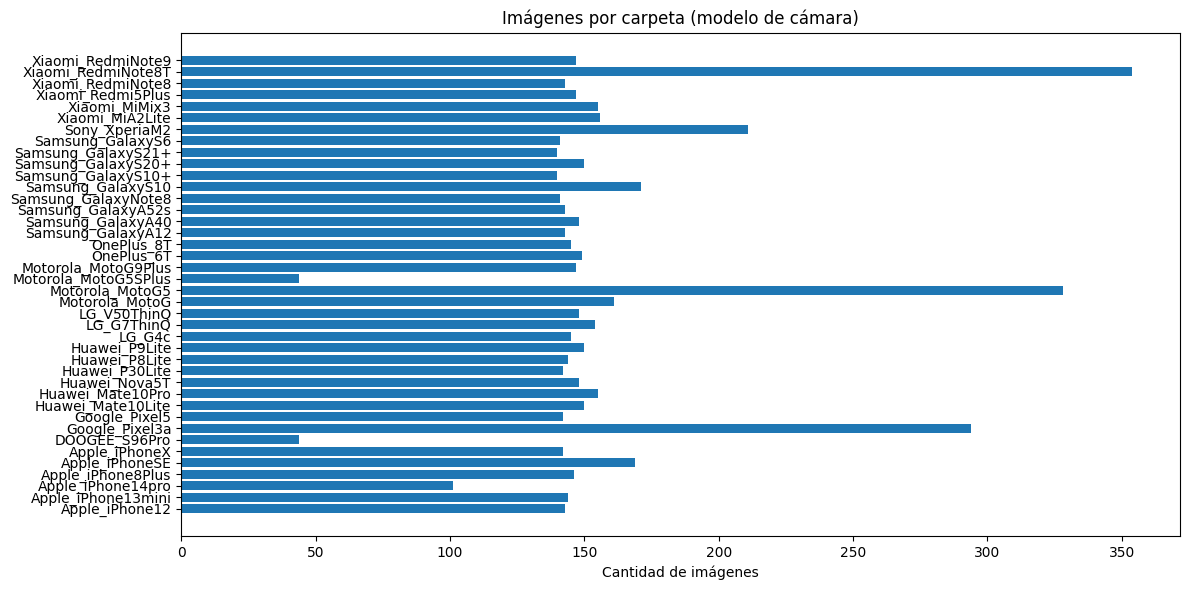

In [10]:
folder_names = []
image_counts = []

for folder in camera_dirs:
    folder_path = os.path.join(DATA_DIR, folder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    folder_names.append(folder)
    image_counts.append(len(files))

plt.figure(figsize=(12, 6))
plt.barh(folder_names, image_counts)
plt.xlabel("Cantidad de imágenes")
plt.title("Imágenes por carpeta (modelo de cámara)")
plt.tight_layout()
plt.show()

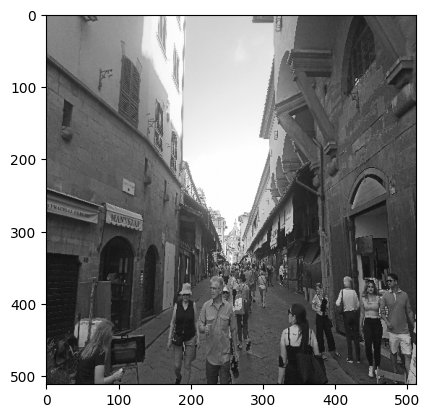

In [12]:
image = cv2.imread('FloreView\DOOGEE_S96Pro\D27_L1S1C1.jpg')
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgray = cv2.resize(imgray, (512,512))
plt.imshow(imgray, cmap='gray')
plt.show()

### *Extracción de parches*

In [40]:
OUTPUT_DIR = "patches2_FloreView"
PATCH_SIZE = 48
PATCHES_PER_IMAGE = 25
BATCH_SIZE = 500

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [41]:
def extract_random_patches(img, num_patches=10, patch_size=48):
    patches = []
    h, w, _ = img.shape
    for _ in range(num_patches):
        y = np.random.randint(0, h - patch_size)
        x = np.random.randint(0, w - patch_size)
        patch = img[y:y+patch_size, x:x+patch_size]
        patches.append(patch)
    return patches

for camera_model in tqdm(os.listdir(DATA_DIR)):
    model_dir = os.path.join(DATA_DIR, camera_model)
    if not os.path.isdir(model_dir):
        continue

    image_files = os.listdir(model_dir)
    num_batches = (len(image_files) + BATCH_SIZE - 1) // BATCH_SIZE

    for batch_idx in range(num_batches):
        start = batch_idx * BATCH_SIZE
        end = min((batch_idx + 1) * BATCH_SIZE, len(image_files))
        batch_files = image_files[start:end]

        patches = []
        labels = []

        for image_file in batch_files:
            img_path = os.path.join(model_dir, image_file)
            img = cv2.imread(img_path)
            if img is None or img.shape[0] < PATCH_SIZE or img.shape[1] < PATCH_SIZE:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            extracted = extract_random_patches(img, PATCHES_PER_IMAGE, PATCH_SIZE)
            patches.extend(extracted)
            labels.extend([camera_model] * len(extracted))

        if patches:
            # normalizar y asegurar tamaño correcto
            patches = [p.astype(np.float32) / 255.0 for p in patches]
            patches = [p for p in patches if p.shape == (PATCH_SIZE, PATCH_SIZE, 3)]
            labels = labels[:len(patches)]  # emparejar cantidad si hubo descarte

            patches_array = np.array(patches)
            labels_array = np.array(labels)

            np.save(os.path.join(OUTPUT_DIR, f"{camera_model}_patches_batch{batch_idx}.npy"), patches_array)
            np.save(os.path.join(OUTPUT_DIR, f"{camera_model}_labels_batch{batch_idx}.npy"), labels_array)
            print(f"Guardado: {camera_model} - batch {batch_idx}")


  2%|▎         | 1/40 [00:09<05:55,  9.13s/it]

Guardado: Apple_iPhone12 - batch 0


  5%|▌         | 2/40 [00:18<05:57,  9.40s/it]

Guardado: Apple_iPhone13mini - batch 0


  8%|▊         | 3/40 [00:23<04:29,  7.28s/it]

Guardado: Apple_iPhone14pro - batch 0


 10%|█         | 4/40 [00:32<04:48,  8.01s/it]

Guardado: Apple_iPhone8Plus - batch 0


 12%|█▎        | 5/40 [00:44<05:28,  9.38s/it]

Guardado: Apple_iPhoneSE - batch 0


 15%|█▌        | 6/40 [00:53<05:19,  9.41s/it]

Guardado: Apple_iPhoneX - batch 0


 15%|█▌        | 6/40 [00:55<05:13,  9.22s/it]


KeyboardInterrupt: 

In [42]:
# Aqui se juntan todos los parches por batches para poder hacer la division del dataset 70-30, toco asi porque crear los parches para todo
# el conjunto de fotos de un solo sensor no se podia (Superaba la ram del Kaggle)

PATCHES_DIR = "patches_Floreview"

all_patches = []
all_labels = []

# Solo buscar archivos que son batches de parches
for fname in sorted(os.listdir(PATCHES_DIR)):
    if "_patches_batch" in fname and fname.endswith(".npy"):
        base_name = fname.replace("_patches_batch", "_labels_batch")
        patches_path = os.path.join(PATCHES_DIR, fname)
        labels_path = os.path.join(PATCHES_DIR, base_name)

        # Verificar que existan ambos archivos
        if not os.path.exists(labels_path):
            print(f" Falta el archivo de etiquetas para: {fname}")
            continue

        # Cargar parches y etiquetas
        patches = np.load(patches_path)
        labels = np.load(labels_path)

        all_patches.append(patches)
        all_labels.append(labels)

# Concatenar todos los arrays
X = np.concatenate(all_patches, axis=0)
y = np.concatenate(all_labels, axis=0)

print(f"Parches totales: {X.shape}")
print(f"Etiquetas totales: {y.shape}")

Parches totales: (156575, 48, 48, 3)
Etiquetas totales: (156575,)


In [43]:
# Asignacion de clases, le asigna una clase a cada sensor, en la siguiente celda puse el print para ver como queda

classes = sorted(np.unique(y))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
y_idx = np.array([class_to_idx[label] for label in y])

In [44]:
print(class_to_idx)

{'Apple_iPhone12': 0, 'Apple_iPhone13mini': 1, 'Apple_iPhone14pro': 2, 'Apple_iPhone8Plus': 3, 'Apple_iPhoneSE': 4, 'Apple_iPhoneX': 5, 'DOOGEE_S96Pro': 6, 'Google_Pixel3a': 7, 'Google_Pixel5': 8, 'Huawei_Mate10Lite': 9, 'Huawei_Mate10Pro': 10, 'Huawei_Nova5T': 11, 'Huawei_P30Lite': 12, 'Huawei_P8Lite': 13, 'Huawei_P9Lite': 14, 'LG_G4c': 15, 'LG_G7ThinQ': 16, 'LG_V50ThinQ': 17, 'Motorola_MotoG': 18, 'Motorola_MotoG5': 19, 'Motorola_MotoG5SPlus': 20, 'Motorola_MotoG9Plus': 21, 'OnePlus_6T': 22, 'OnePlus_8T': 23, 'Samsung_GalaxyA12': 24, 'Samsung_GalaxyA40': 25, 'Samsung_GalaxyA52s': 26, 'Samsung_GalaxyNote8': 27, 'Samsung_GalaxyS10': 28, 'Samsung_GalaxyS10+': 29, 'Samsung_GalaxyS20+': 30, 'Samsung_GalaxyS21+': 31, 'Samsung_GalaxyS6': 32, 'Sony_XperiaM2': 33, 'Xiaomi_MiA2Lite': 34, 'Xiaomi_MiMix3': 35, 'Xiaomi_Redmi5Plus': 36, 'Xiaomi_RedmiNote8': 37, 'Xiaomi_RedmiNote8T': 38, 'Xiaomi_RedmiNote9': 39}


In [45]:
#Split 70-30

X_train, X_test, y_train, y_test = train_test_split(
    X, y_idx, test_size=0.3, stratify=y_idx, random_state=42
)

In [46]:
#Aqui se guardan los splits para no hacer lo mismo cada vez que entremos al notebook

os.makedirs("FloreView_split", exist_ok=True)
np.save("FloreView_split/X_train.npy", X_train)
np.save("FloreView_split/X_test.npy", X_test)
np.save("FloreView_split/y_train.npy", y_train)
np.save("FloreView_split/y_test.npy", y_test)
np.save("FloreView_split/class_to_idx.npy", class_to_idx)

In [5]:
class CameraConvNet(nn.Module):
    def __init__(self, num_classes):
        super(CameraConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 512, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(512, 2048, kernel_size=6),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2048, num_classes)  # ajustable al nuevo dataset
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [54]:
#Carga los splits y los convierte en tensores de pytorch para crear los Dataloaders

DATA_DIR="FloreView_split"

X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))
class_to_idx = np.load(os.path.join(DATA_DIR, "class_to_idx.npy"), allow_pickle=True).item()

# Convertir a tensores PyTorch
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()  # [N, C, H, W]
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()
y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

# Crear Datasets y DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)



In [12]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import os
import torch

# 📂 Cargar datos
DATA_DIR = "FloreView_split"

X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))
class_to_idx = np.load(os.path.join(DATA_DIR, "class_to_idx.npy"), allow_pickle=True).item()

# 🔁 Convertir a tensores PyTorch
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()  # [N, C, H, W]
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()
y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

# 🎨 Transformaciones para data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class TransformedTensorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]  # [C, H, W] ya está así por permute
        label = self.labels[idx]

        image = image.permute(1, 2, 0).numpy()  # [H, W, C]
        image = (image * 255).astype("uint8")   # de [0,1] float32 → [0,255] uint8
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = TransformedTensorDataset(X_train_tensor, y_train_tensor, transform=transform_train)
test_dataset = TransformedTensorDataset(X_test_tensor, y_test_tensor, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
import wandb
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
import torch
import numpy as np

wandb.init(
    project="camera-identification",
    name="finetuning_floreview",
    config={
        "dataset": "FloreView",
        "architecture": "CameraConvNet",
        "batch_size": 256,
        "epochs": 200,
        "optimizer": "AdamW",
        "learning_rate": 0.001,
        "patch_size": 48
    }
)

scaler = GradScaler()
epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_to_idx)
model = CameraConvNet(num_classes).to(device)

checkpoint = torch.load("checkpoints/checkpoint_epoch100.pth")
filtered_checkpoint = {k: v for k, v in checkpoint.items() if not k.startswith("classifier.3")}
model.load_state_dict(filtered_checkpoint, strict=False)

torch.nn.init.xavier_uniform_(model.classifier[3].weight)
torch.nn.init.zeros_(model.classifier[3].bias)

for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ----- VALIDACIÓN -----
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = np.mean(np.array(y_true) == np.array(y_pred))

    # Calcular métricas cada 5 épocas
    if (epoch + 1) % 5 == 0:
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    else:
        precision = recall = f1 = None

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    log_dict = {
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
    }
    if precision is not None:
        log_dict.update({
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1
        })

    wandb.log(log_dict)

    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"finetune_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint guardado: {checkpoint_path}")

wandb.finish()

epoch,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
epoch,1
train_accuracy,0.11127
train_loss,4.25144
val_accuracy,0.1824
val_loss,3.06569


RuntimeError: DataLoader worker (pid(s) 18816, 4336, 7144, 15704) exited unexpectedly